In [1]:
# Fixando o Random Seed
import random
import numpy as np
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
# Preparar o Dataset
import pandas as pd
from pathlib import Path


caminho_arquivo = Path("dataset") / "Breast_cancer_dataset.csv"

# Carrega o CSV em um DataFrame
df = pd.read_csv(caminho_arquivo)


df.head()
df.info()
df.describe()

# Codificar a variável alvo
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Features e alvo
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

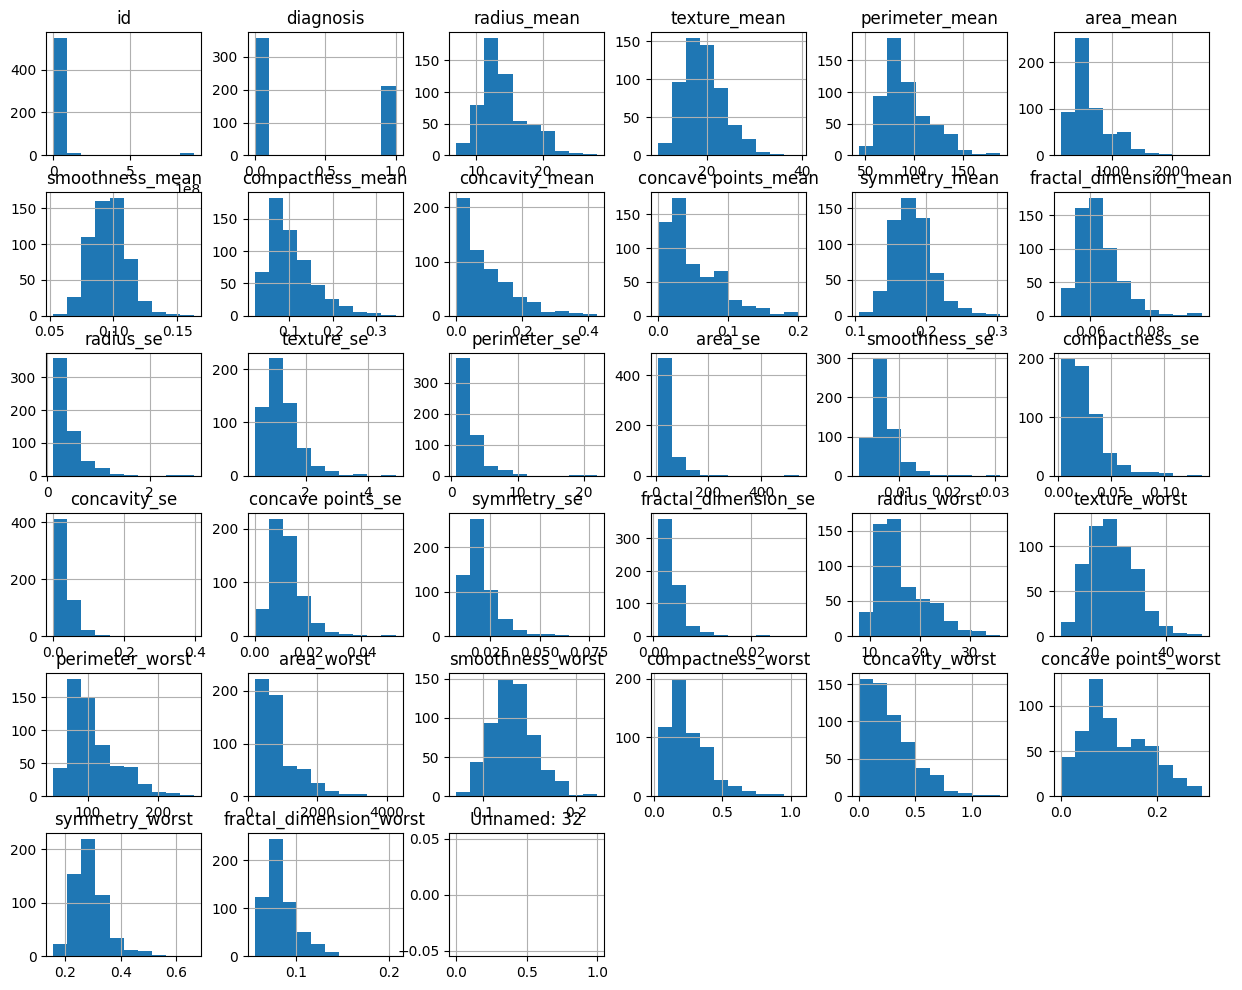

In [3]:
import matplotlib.pyplot as plt
df.hist(figsize=(15, 12))
plt.show()

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

# --- BLOCO DE PRÉ-PROCESSAMENTO FINAL ---

# Etapa 0: Remover colunas que são INTEIRAMENTE vazias (só contêm NaN)
print(f"Shape original de X: {X.shape}")
X.dropna(axis=1, how='all', inplace=True)
print(f"Shape de X após remover colunas totalmente vazias: {X.shape}")


# Etapa 1: Separar as colunas numéricas das categóricas
numeric_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(exclude=np.number).columns

print(f"\nColunas numéricas identificadas: {numeric_cols.tolist()}")
print(f"Colunas categóricas identificadas: {categorical_cols.tolist()}")


# Etapa 2: Processar as colunas NUMÉRICAS
X_numeric = X[numeric_cols]
imputer = SimpleImputer(strategy='mean')
# Esta linha agora deve funcionar, pois não há mais colunas 100% NaN
X_numeric_imputed = imputer.fit_transform(X_numeric)
X_numeric_imputed_df = pd.DataFrame(X_numeric_imputed, columns=numeric_cols, index=X.index)

scaler = StandardScaler()
X_numeric_scaled = scaler.fit_transform(X_numeric_imputed_df)
X_numeric_scaled_df = pd.DataFrame(X_numeric_scaled, columns=numeric_cols, index=X.index)


# Etapa 3: Processar as colunas CATEGÓRICAS (se existirem)
if not categorical_cols.empty:
    X_categorical = X[categorical_cols]
    X_categorical_encoded = pd.get_dummies(X_categorical, prefix=categorical_cols, dummy_na=True)
    # Etapa 4: Juntar os dados processados
    X_processed = pd.concat([X_numeric_scaled_df, X_categorical_encoded], axis=1)
else:
    # Se não houver colunas categóricas, X_processed é apenas a parte numérica
    X_processed = X_numeric_scaled_df


print(f"\nDimensões de X após pré-processamento completo: {X_processed.shape}")


# Etapa 5: Seleção de Features
k_features = min(20, X_processed.shape[1])
selector = SelectKBest(score_func=f_classif, k=k_features)
X_selected = selector.fit_transform(X_processed.values, y)

selected_cols = X_processed.columns[selector.get_support()]

print(f"\nProcesso concluído com sucesso!")
print(f"Shape de X_selected: {X_selected.shape}")
print(f"Features selecionadas: {selected_cols.tolist()}")










Shape original de X: (569, 32)
Shape de X após remover colunas totalmente vazias: (569, 31)

Colunas numéricas identificadas: ['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
Colunas categóricas identificadas: []

Dimensões de X após pré-processamento completo: (569, 31)

Processo concluído com sucesso!
Shape de X_selected: (569, 20)
Features selecionadas: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'radius_se', '

In [5]:
# Separação Treino/Teste
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=SEED, stratify=y
)
# stratify=y mantém a proporção de classes no treino e teste

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, recall_score
import warnings
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, recall_score
warnings.filterwarnings('ignore')

# Validação cruzada estratificada com 5 divisões
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Definindo scorer de Recall
recall_scorer = make_scorer(recall_score)

modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=SEED),
    "Random Forest": RandomForestClassifier(random_state=SEED),
    "Gradient Boosting": GradientBoostingClassifier(random_state=SEED),
    "SVM": SVC(probability=True, random_state=SEED),
    "KNN": KNeighborsClassifier(),
}

resultados = {}

for nome, modelo in modelos.items():
    recall_scores = cross_val_score(modelo, X_selected, y, cv=skf, scoring=recall_scorer)
    resultados[nome] = recall_scores.mean()
    print(f"\nModelo: {nome}")
    print(f"Recall médio (5 folds): {recall_scores.mean():.4f} ± {recall_scores.std():.4f}")

melhor_modelo_nome = max(resultados, key=resultados.get)
print("\nMelhor modelo baseado em Recall médio:", melhor_modelo_nome, "->", resultados[melhor_modelo_nome])



Modelo: Logistic Regression
Recall médio (5 folds): 0.9529 ± 0.0492

Modelo: Random Forest
Recall médio (5 folds): 0.9295 ± 0.0509

Modelo: Gradient Boosting
Recall médio (5 folds): 0.9106 ± 0.0475

Modelo: SVM
Recall médio (5 folds): 0.9530 ± 0.0417

Modelo: KNN
Recall médio (5 folds): 0.9293 ± 0.0535

Melhor modelo baseado em Recall médio: SVM -> 0.953045404208195


In [7]:
# MLP Otimizada para Recall
# Depois de encontrar o melhor modelo geral, ainda podemos treinar a MLP focando recall
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.callbacks import EarlyStopping

model = models.Sequential([
    layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', metrics.Recall(name='recall')]
)

early_stop = EarlyStopping(monitor='val_recall', mode='max', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=1000,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

# Predição com threshold ajustado para recall
y_pred_probs = model.predict(X_test)
y_pred_adj = (y_pred_probs > 0.3).astype(int)
print("\nRelatório com threshold 0.3")
print(classification_report(y_test, y_pred_adj, digits=4))


Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4440 - loss: 0.8382 - recall: 0.2765 - val_accuracy: 0.5000 - val_loss: 0.7737 - val_recall: 0.2381
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6593 - loss: 0.6641 - recall: 0.3941 - val_accuracy: 0.6491 - val_loss: 0.6292 - val_recall: 0.4048
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7934 - loss: 0.5352 - recall: 0.5882 - val_accuracy: 0.7544 - val_loss: 0.5170 - val_recall: 0.5476
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8945 - loss: 0.4386 - recall: 0.8000 - val_accuracy: 0.8421 - val_loss: 0.4301 - val_recall: 0.7381
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9275 - loss: 0.3634 - recall: 0.8882 - val_accuracy: 0.8860 - val_loss: 0.3600 - val_recall: 0.8095
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9363 - loss: 0.3051 - recall: 0.9118 - val_accuracy: 0.9123 - val_loss: 0.3038 - val_recall: 0.8571
Epo

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        72
           1       0.95      0.93      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



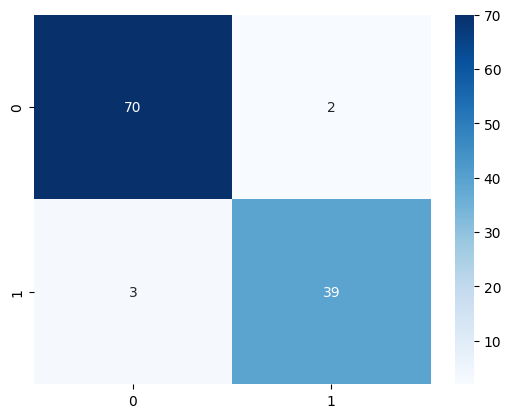

In [8]:
# Resultados
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = (model.predict(X_test) > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

print(classification_report(y_test, y_pred))